# 0. Импорты и загрузка данных

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

mpl.rcParams["figure.figsize"] = (9, 6)
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["savefig.dpi"] = 300

from src.data.load_events import load_raw_events, add_basic_time_cols

# Загружаем сырой датасет и добавляем базовые временные колонки
df = load_raw_events("data/raw/датасет_new.csv")
df = add_basic_time_cols(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6269242 entries, 0 to 6269241
Data columns (total 14 columns):
 #   Column                            Dtype              
---  ------                            -----              
 0   Дата и время события              datetime64[ns, UTC]
 1   Экран                             object             
 2   Функционал                        object             
 3   Действие                          object             
 4   Идентификатор устройства          int64              
 5   Номер сессии в рамках устройства  int64              
 6   Производитель устройства          object             
 7   Модель устройства                 object             
 8   Тип устройства                    object             
 9   ОС                                object             
 10  date                              object             
 11  hour                              int32              
 12  weekday                           int32              
 1

# 1. Категориальные признаки + пропуски

In [7]:
# Категориальные признаки
cat_cols = [
    'Экран', 'Функционал', 'Действие',
    'Производитель устройства', 'Модель устройства',
    'Тип устройства', 'ОС'
]

for col in cat_cols:
    df[col] = df[col].astype('category')

# Пропуски по всем колонкам
df.isna().mean().sort_values(ascending=False).head(10)


Действие                            0.518884
Дата и время события                0.000000
Экран                               0.000000
Функционал                          0.000000
Идентификатор устройства            0.000000
Номер сессии в рамках устройства    0.000000
Производитель устройства            0.000000
Модель устройства                   0.000000
Тип устройства                      0.000000
ОС                                  0.000000
dtype: float64

In [8]:
df['Действие'] = df['Действие'].cat.add_categories(['no_action'])
df['Действие'] = df['Действие'].fillna('no_action')


# 2. Базовые описательные статистики

In [9]:
print("Число событий:", len(df))
print("Уникальных устройств:", df['Идентификатор устройства'].nunique())
print("Уникальных сессий:", df['Номер сессии в рамках устройства'].nunique())
print("Диапазон дат:", df['Дата и время события'].min(), "→", df['Дата и время события'].max())

Число событий: 6269242
Уникальных устройств: 179976
Уникальных сессий: 8822
Диапазон дат: 2025-08-31 21:00:05+00:00 → 2025-10-31 20:59:54+00:00


# 3. Временные паттерны

## 3.1. События по дням

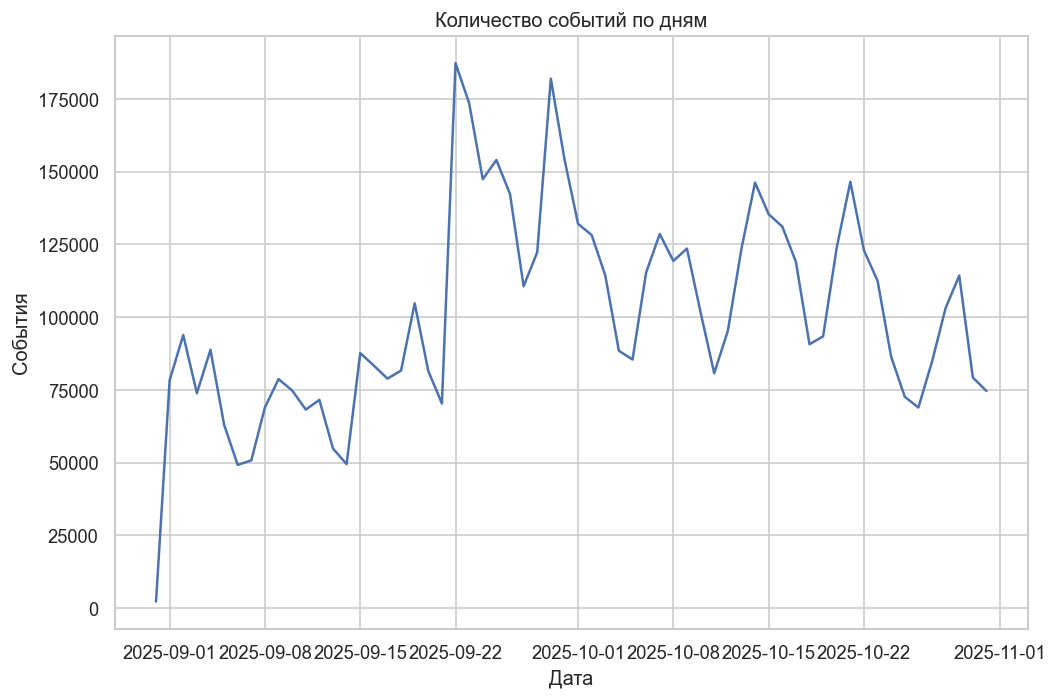

In [10]:
events_per_day = df.groupby('date').size()

events_per_day.plot()
plt.title("Количество событий по дням")
plt.ylabel("События")
plt.xlabel("Дата")

plt.grid(True)
plt.tight_layout()
plt.show()

## 3.2. События по часам

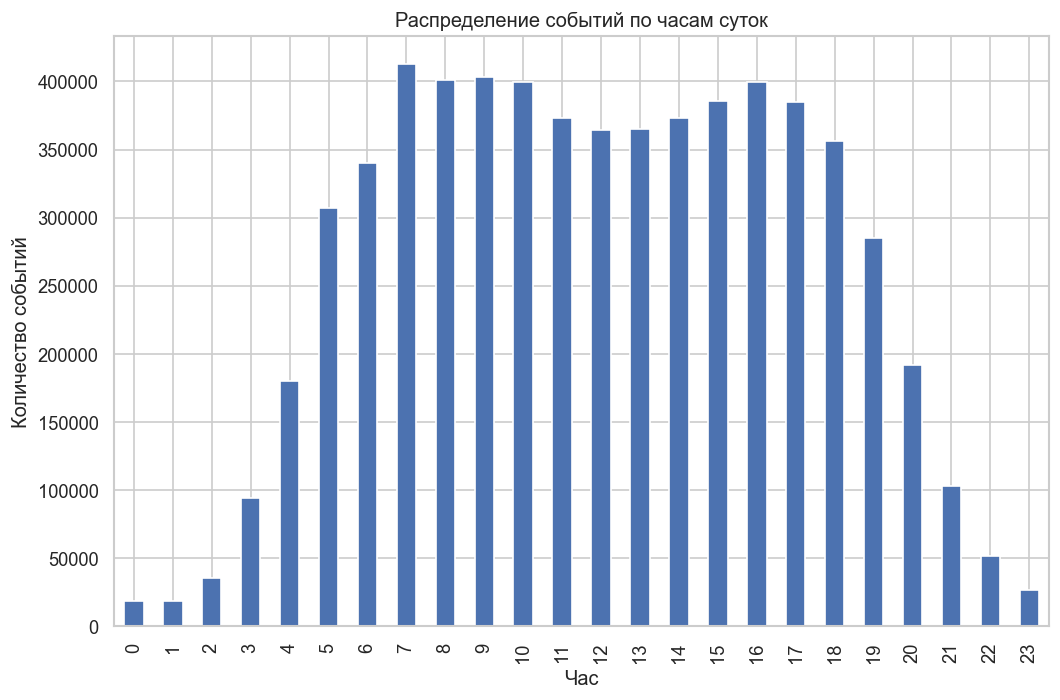

In [11]:
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title("Распределение событий по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество событий")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. ОС, устройства, экраны

## 4.1. ОС

In [12]:
df['ОС'].value_counts(normalize=True) * 100

ОС
Android    61.940853
iOS        38.059147
Name: proportion, dtype: float64

## 4.2. Топ экранов

In [13]:
df['Экран'].value_counts().head(15)
df['Экран'].value_counts(normalize=True).head(15) * 100

Экран
Еще                          50.440213
Новая заявка                 25.801285
Заявки                        9.131806
Важное                        6.971656
Мой дом                       2.479454
Услуги                        1.721596
Мои баллы                     1.267984
Гостевой доступ               0.665806
Новое ОСС                     0.614971
Объявления                    0.564678
Связаться с владельцем ТС     0.221526
Новый адрес                   0.102054
Техподдержка                  0.016972
Name: proportion, dtype: float64

## 4.3. Тип устройства × ОС

In [14]:
pd.crosstab(df['ОС'], df['Тип устройства'], normalize='index') * 100

Тип устройства,phone,tablet
ОС,,
Android,98.784669,1.215331
iOS,99.263082,0.736918


## 4.4. Топ производителей и моделей

In [16]:
df['Производитель устройства'].value_counts().head(10)

Производитель устройства
Apple      2386020
Samsung    1240786
Redmi       631114
Huawei      400492
Xiaomi      378089
POCO        272984
Realme      229779
Honor       175319
Tecno       120511
OnePlus      80809
Name: count, dtype: int64

In [17]:
df['Модель устройства'].value_counts().head(10)

Модель устройства
iPhone 11            215366
iPhone 15 Pro Max    167792
iPhone 13            167140
iPhone 16 Pro Max    157305
iPhone 14 Pro Max    148218
iPhone 13 Pro Max    128199
iPhone 15 Pro        123998
iPhone 16 Pro        117467
iPhone 14 Pro        116971
iPhone 13 Pro        113061
Name: count, dtype: int64

## 5. Дни недели + day×hour heatmap

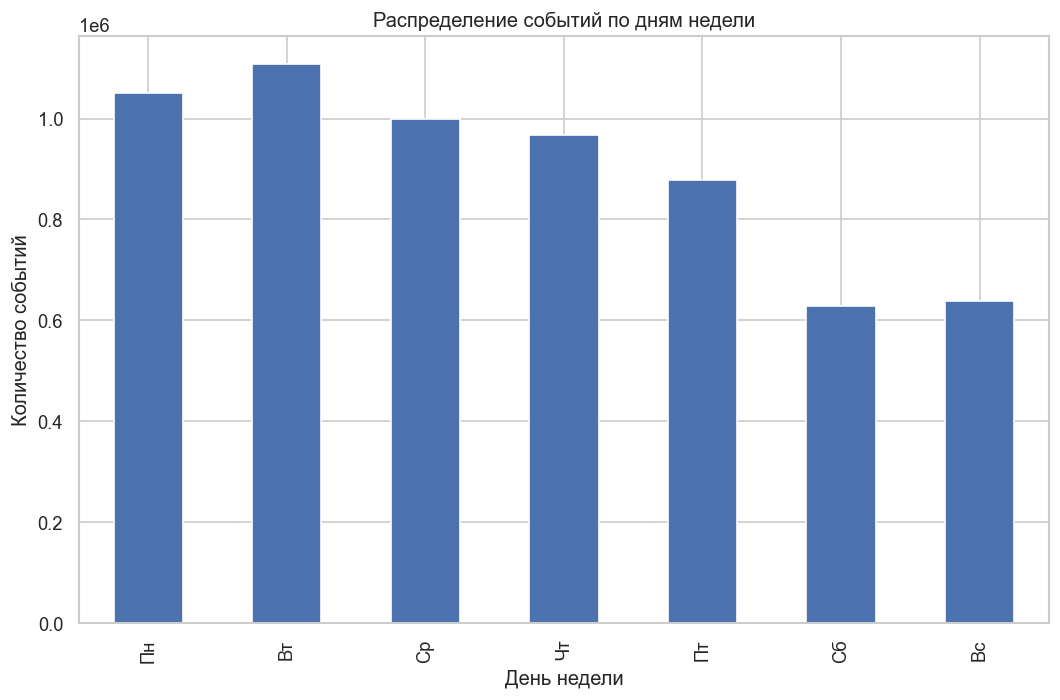

In [18]:
weekday_map = {
    0: "Пн", 1: "Вт", 2: "Ср",
    3: "Чт", 4: "Пт", 5: "Сб", 6: "Вс"
}

events_per_weekday = df['weekday'].map(weekday_map).value_counts().reindex(
    ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]
)

events_per_weekday.plot(kind='bar')
plt.title("Распределение событий по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество событий")
plt.tight_layout()
plt.show()

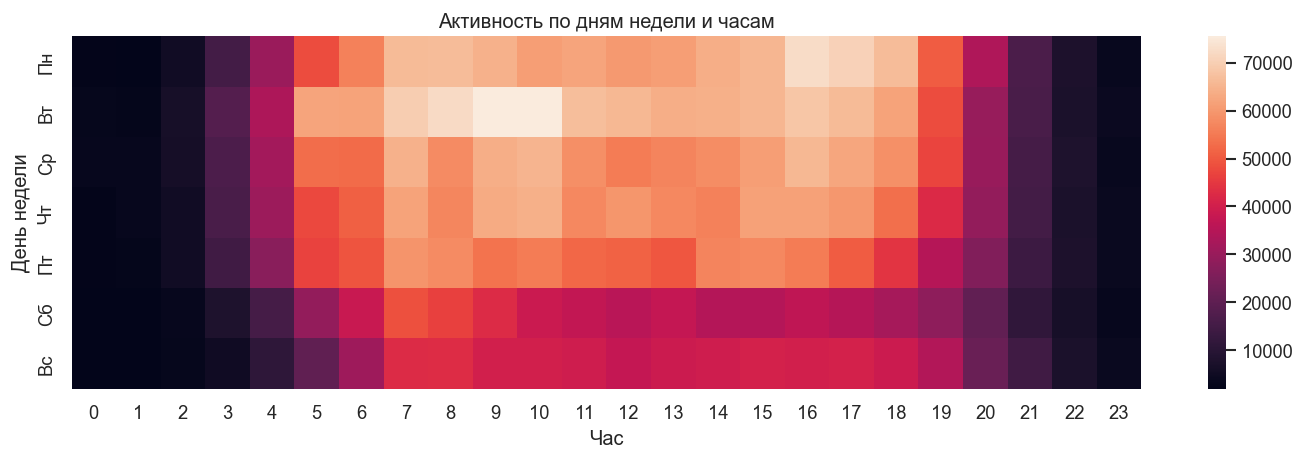

In [19]:
pivot = df.pivot_table(
    index='weekday',
    columns='hour',
    values='Идентификатор устройства',
    aggfunc='count',
    fill_value=0
)

pivot.index = pivot.index.map(weekday_map)

plt.figure(figsize=(12, 4))
sns.heatmap(pivot, annot=False)
plt.title("Активность по дням недели и часам")
plt.xlabel("Час")
plt.ylabel("День недели")
plt.tight_layout()
plt.show()

# 6. Функционал, действия

## 6.1. Функционал

In [20]:
func_counts = df['Функционал'].value_counts().head(15)
func_props = df['Функционал'].value_counts(normalize=True).head(15) * 100

func_table = pd.concat([func_counts, func_props], axis=1)
func_table.columns = ['count', 'proportion']
func_table

,count,proportion
Функционал,,
Открытие экрана,3241298,51.701593
Просмотр уведомления,437070,6.971656
Переход в раздел 'Заявки',362620,5.784112
Возврат на предыдущий этап,258090,4.116766
Выбор через теги,249918,3.986415
Переход в раздел 'Опросы и собрания собственников',238955,3.811545
Переход к просмотру заявки,159041,2.536846
Выбор квартиры,121743,1.941909
Переход в раздел 'Приборы учета',120716,1.925528


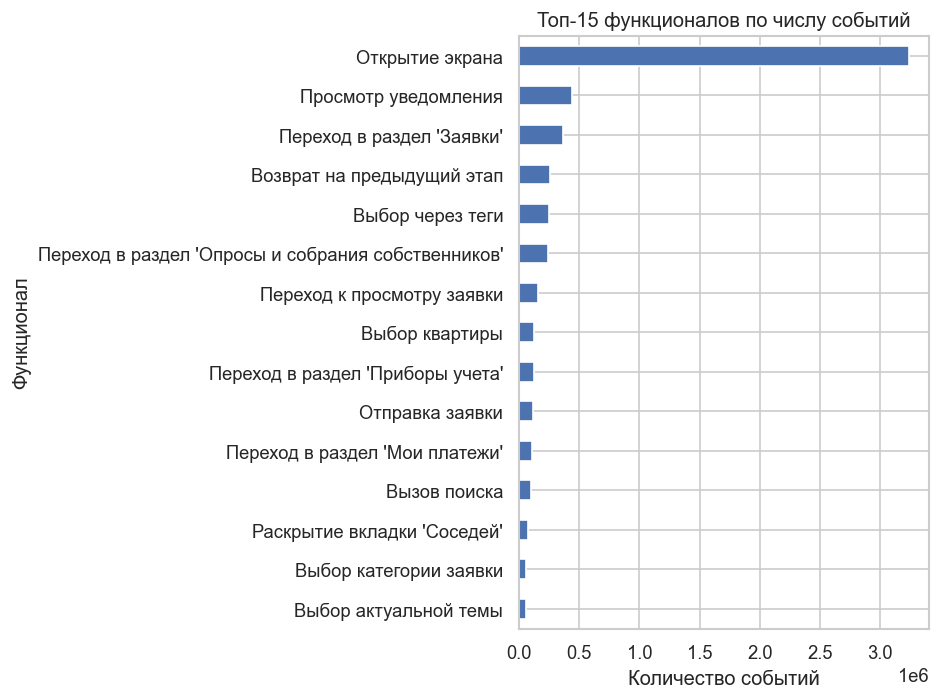

In [21]:
func_counts.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Топ-15 функционалов по числу событий")
plt.xlabel("Количество событий")
plt.tight_layout()
plt.show()

## 6.2. Экран × ОС

In [22]:
screen_os = pd.crosstab(df['Экран'], df['ОС'], normalize='columns') * 100
screen_os.head(10)


ОС,Android,iOS
Экран,,
Важное,6.949513,7.007695
Гостевой доступ,0.857870,0.353224
Еще,44.509843,60.091827
Заявки,9.770108,8.092975
Мои баллы,1.342442,1.146805
Мой дом,3.895270,0.175229
Новая заявка,29.188725,20.288262
Новое ОСС,0.513929,0.779415
Новый адрес,0.160228,0.007376


## 6.3. Действия

In [23]:
action_counts = df['Действие'].value_counts().head(20)
action_counts

Действие
no_action                                          3253007
Тап на уведомление                                  437070
Тап на кнопку 'Заявки'                              362620
Тап на стрелку назад                                258090
Тап на кнопку 'Опросы и собрания собственников'     238955
Тап на заявку                                       159041
Тап на квартиру                                     121743
Тап на кнопку 'Создать заявку'                      114778
Тап на кнопку 'Мои платежи'                         108710
Тап на кнопку поиска                                101161
выбор тега 1                                         93852
Тап на кнопку 'Приборы учёта'                        82467
Тап на кнопку 'Соседей'                              78648
Выбор тега 1                                         57647
Тап на категорию                                     54934
Тап на кнопку 'Профиль'                              51991
Открытие экрана                                

## 7. Пользовательский уровень и черновой churn

In [24]:
user_agg = df.groupby('Идентификатор устройства').agg(
    events_total=('Дата и время события', 'size'),
    sessions_total=('Номер сессии в рамках устройства', 'nunique'),
    first_event=('Дата и время события', 'min'),
    last_event=('Дата и время события', 'max')
).reset_index()

user_agg['active_days'] = (user_agg['last_event'] - user_agg['first_event']).dt.days + 1

In [25]:
user_agg['events_total'].describe()
user_agg['sessions_total'].describe()
user_agg['active_days'].describe()

count    179976.00000
mean         17.26014
std          17.62591
min           1.00000
25%           1.00000
50%          11.00000
75%          31.00000
max          61.00000
Name: active_days, dtype: float64

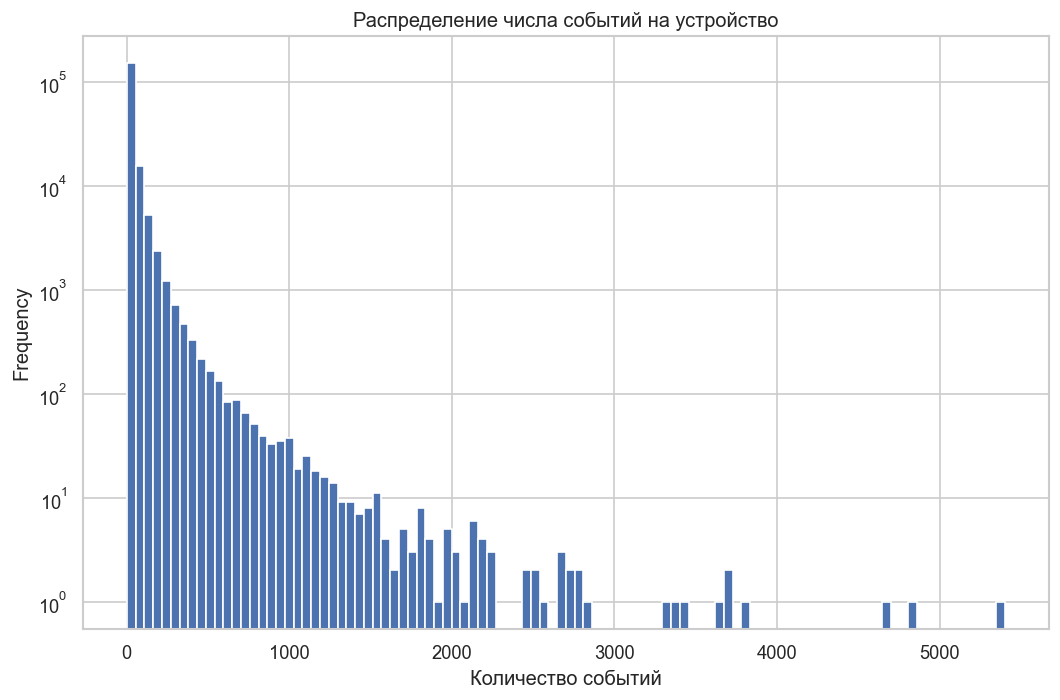

In [26]:
user_agg['events_total'].plot(kind='hist', bins=100, logy=True)
plt.title("Распределение числа событий на устройство")
plt.xlabel("Количество событий")
plt.tight_layout()
plt.grid(True)
plt.show()

## 7.1. Черновой churn_30d

In [27]:
max_date = df['Дата и время события'].max()

user_agg['recency_days'] = (max_date - user_agg['last_event']).dt.days
user_agg['churn_30d'] = (user_agg['recency_days'] > 30).astype(int)

user_agg['churn_30d'].value_counts(normalize=True) * 100

churn_30d
0    67.105058
1    32.894942
Name: proportion, dtype: float64

# 8. Сессии и дополнительные метрики

In [28]:
df['session_id'].nunique()

1002265

In [29]:
session_agg = df.groupby('session_id').agg(
    device_id=('Идентификатор устройства', 'first'),
    events_in_session=('Дата и время события', 'size'),
    session_start=('Дата и время события', 'min'),
    session_end=('Дата и время события', 'max')
).reset_index()

session_agg['session_duration_sec'] = (
    session_agg['session_end'] - session_agg['session_start']
).dt.total_seconds()

## 8.1. Сравнение метрик по churn

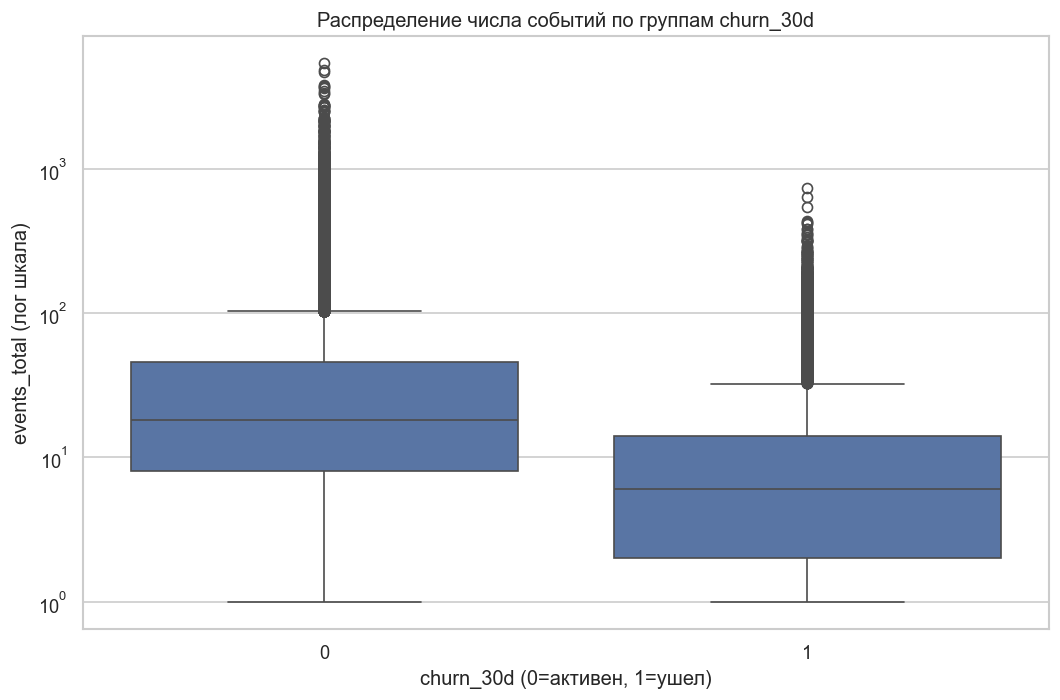

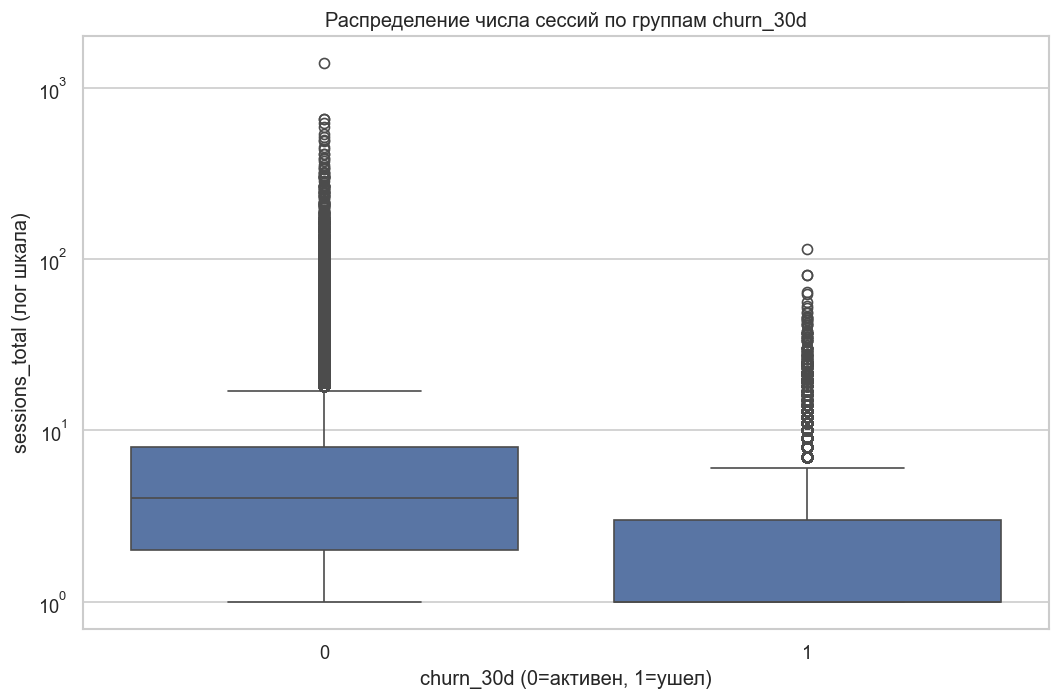

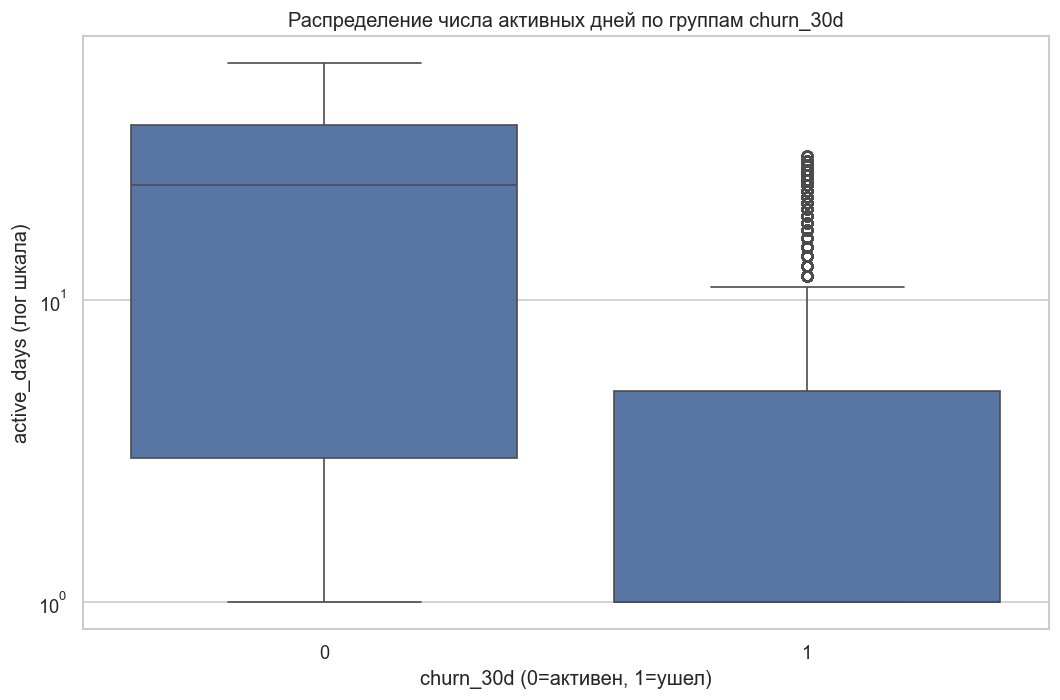

In [30]:
sns.boxplot(data=user_agg, x='churn_30d', y='events_total')
plt.yscale('log')
plt.title("Распределение числа событий по группам churn_30d")
plt.xlabel("churn_30d (0=активен, 1=ушел)")
plt.ylabel("events_total (лог шкала)")
plt.tight_layout()
plt.show()

sns.boxplot(data=user_agg, x='churn_30d', y='sessions_total')
plt.yscale('log')
plt.title("Распределение числа сессий по группам churn_30d")
plt.xlabel("churn_30d (0=активен, 1=ушел)")
plt.ylabel("sessions_total (лог шкала)")
plt.tight_layout()
plt.show()

sns.boxplot(data=user_agg, x='churn_30d', y='active_days')
plt.yscale('log')
plt.title("Распределение числа активных дней по группам churn_30d")
plt.xlabel("churn_30d (0=активен, 1=ушел)")
plt.ylabel("active_days (лог шкала)")
plt.tight_layout()
plt.show()


## 8.2. ОС × churn

In [31]:
user_os = df.groupby('Идентификатор устройства')['ОС'].agg(lambda x: x.mode()[0]).reset_index()
user_agg_os = user_agg.merge(user_os, on='Идентификатор устройства', how='left')

pd.crosstab(user_agg_os['ОС'], user_agg_os['churn_30d'], normalize='index') * 100

churn_30d,0,1
ОС,,
Android,71.188119,28.811881
iOS,63.853233,36.146767


## 8.3. Разнообразие экранов

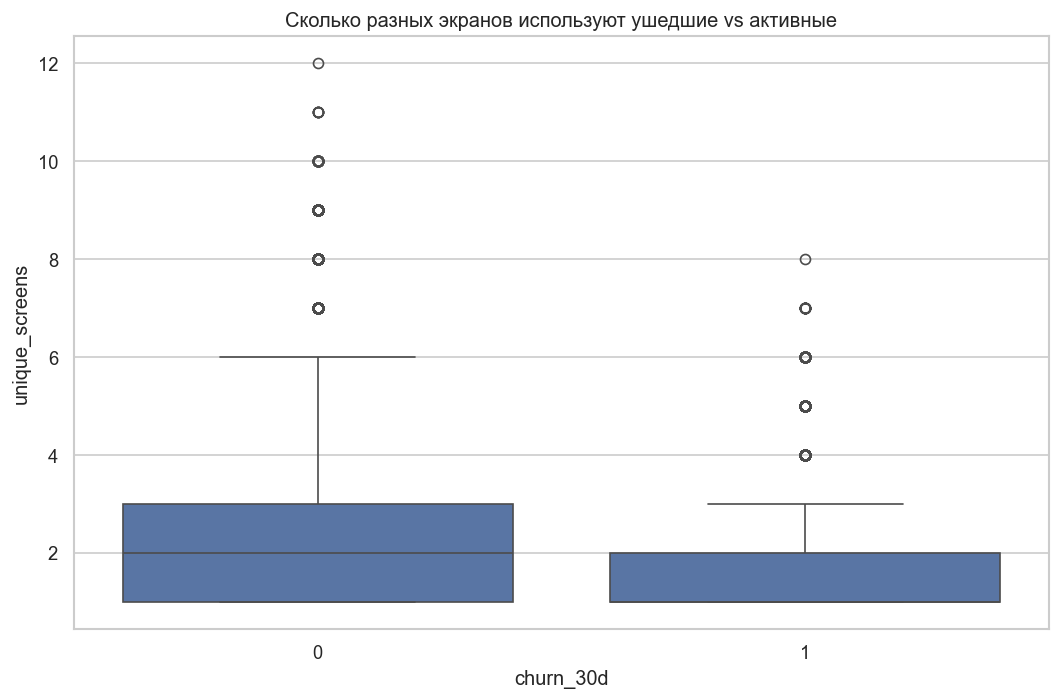

In [32]:
user_screens = df.groupby('Идентификатор устройства')['Экран'].nunique().reset_index(name='unique_screens')
user_agg = user_agg.merge(user_screens, on='Идентификатор устройства', how='left')

user_agg['unique_screens'].describe()

sns.boxplot(data=user_agg, x='churn_30d', y='unique_screens')
plt.title("Сколько разных экранов используют ушедшие vs активные")
plt.tight_layout()
plt.show()

## 8.4. Средняя длина сессий на пользователя

In [33]:
session_by_user = session_agg.groupby('device_id').agg(
    mean_session_events=('events_in_session', 'mean'),
    mean_session_duration=('session_duration_sec', 'mean')
).reset_index().rename(columns={'device_id': 'Идентификатор устройства'})

user_agg = user_agg.merge(session_by_user, on='Идентификатор устройства', how='left')
user_agg.head()

,Идентификатор устройства,events_total,sessions_total,first_event,last_event,active_days,recency_days,churn_30d,unique_screens,mean_session_events,mean_session_duration
0,1,942,70,2025-09-01 08:31:05+00:00,2025-10-30 18:50:59+00:00,60,1,0,6,13.457143,53.642857
1,2,244,44,2025-09-19 17:38:56+00:00,2025-10-20 08:47:36+00:00,31,11,0,5,5.545455,13.590909
2,3,40,3,2025-10-09 09:20:36+00:00,2025-10-20 10:34:50+00:00,12,11,0,2,13.333333,129.000000
3,4,150,10,2025-10-04 10:08:08+00:00,2025-10-25 21:28:28+00:00,22,5,0,5,15.000000,74.200000
4,5,6,2,2025-10-20 09:41:02+00:00,2025-10-23 02:52:28+00:00,3,8,0,1,3.000000,1.500000


## 9. Дополнительные гистограммы и boxplot’ы

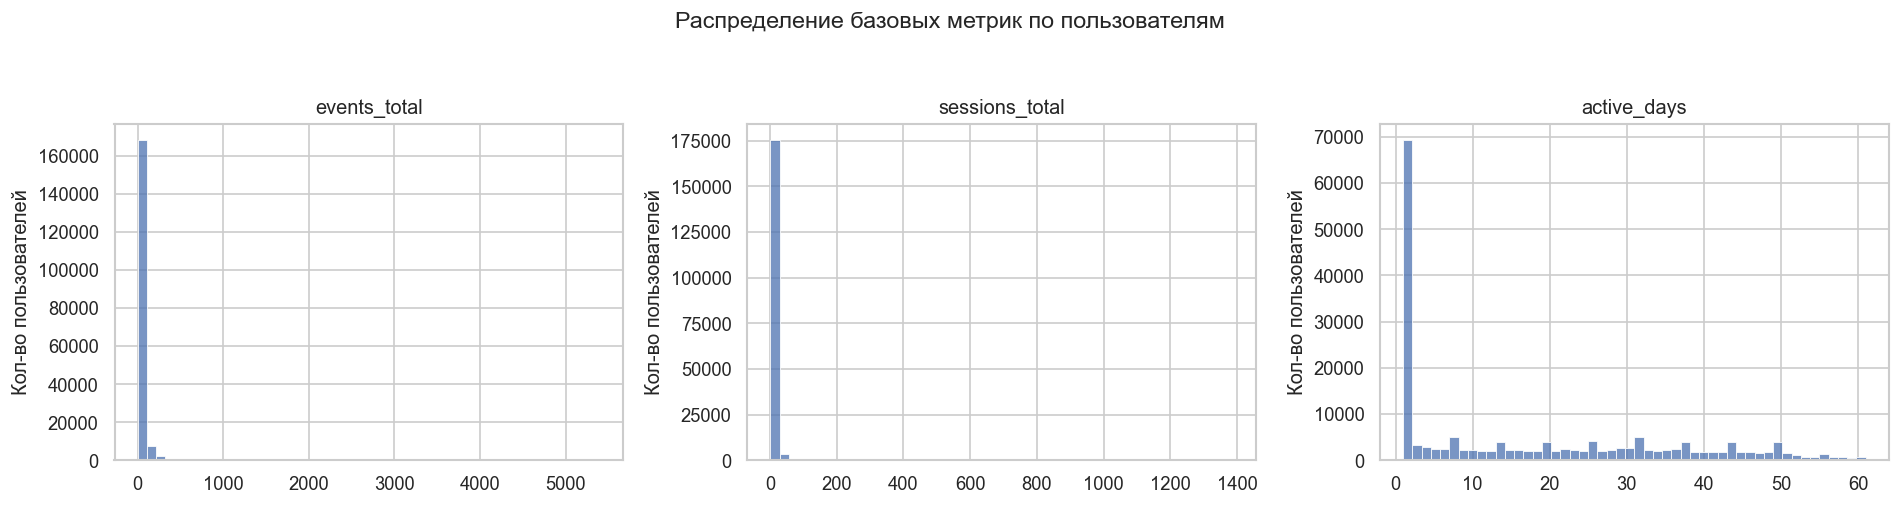

In [35]:
metrics = ['events_total', 'sessions_total', 'active_days']

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 4))

for ax, col in zip(axes, metrics):
    sns.histplot(user_agg[col], bins=50, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Кол-во пользователей')

plt.suptitle("Распределение базовых метрик по пользователям", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

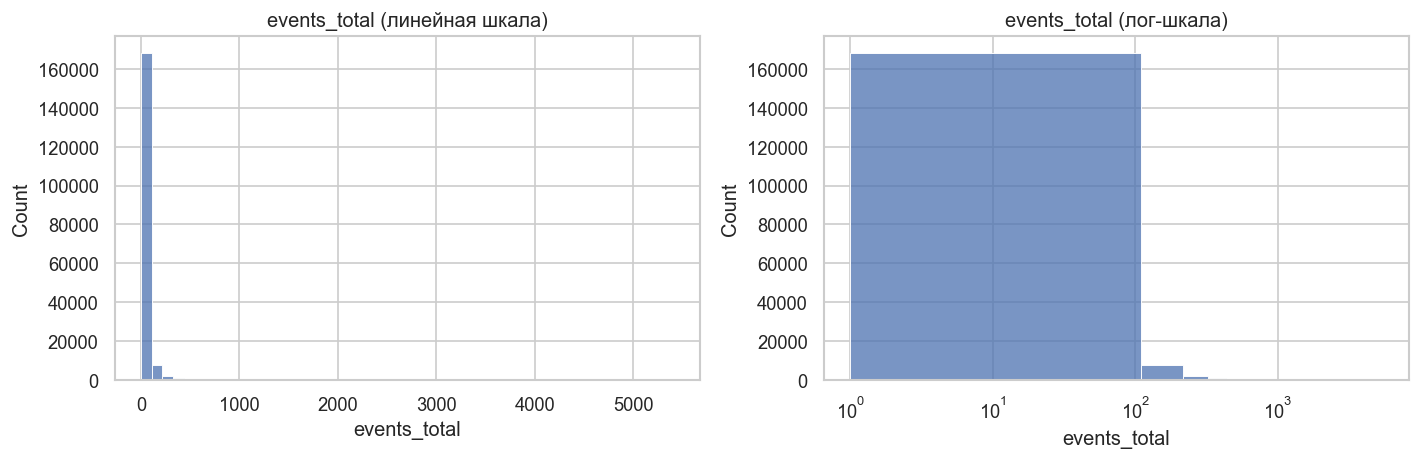

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(user_agg['events_total'], bins=50, ax=axes[0])
axes[0].set_title("events_total (линейная шкала)")

sns.histplot(user_agg['events_total'], bins=50, ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_title("events_total (лог-шкала)")

plt.tight_layout()
plt.show()

# 10. Customer journey

C:\Users\User\AppData\Local\Temp\ipykernel_23892\304446346.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transitions_count = transitions.groupby(['prev_screen', 'Экран']).size().reset_index(name='count')


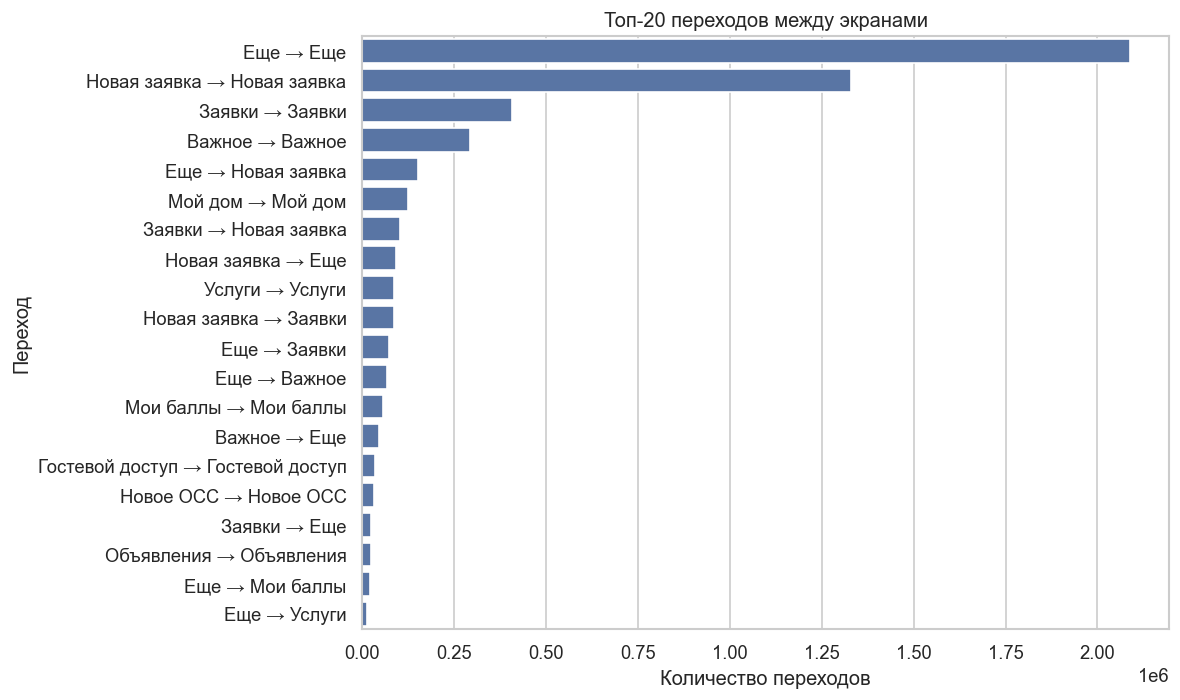

In [37]:
df_sorted = df.sort_values(
    ['Идентификатор устройства', 'Номер сессии в рамках устройства', 'Дата и время события']
)

df_sorted['prev_screen'] = df_sorted.groupby(
    ['Идентификатор устройства', 'Номер сессии в рамках устройства']
)['Экран'].shift(1)

transitions = df_sorted.dropna(subset=['prev_screen'])

transitions_count = transitions.groupby(['prev_screen', 'Экран']).size().reset_index(name='count')

top_n = 20
top_transitions = (
    transitions_count
    .sort_values('count', ascending=False)
    .head(top_n)
    .copy()
)

top_transitions['transition'] = (
    top_transitions['prev_screen'].astype(str)
    + ' → '
    + top_transitions['Экран'].astype(str)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_transitions,
    x='count',
    y='transition'
)
plt.title(f"Топ-{top_n} переходов между экранами")
plt.xlabel("Количество переходов")
plt.ylabel("Переход")
plt.tight_layout()
plt.show()

In [41]:
import plotly.graph_objects as go

# ограничим только наиболее важными экранами, чтобы картинка была читаемой
important_screens = ['Еще', 'Новая заявка', 'Заявки', 'Мой дом', 'Мои платежи', 'Услуги']

trans_filt = transitions_count[
    transitions_count['prev_screen'].isin(important_screens)
    & transitions_count['Экран'].isin(important_screens)
]

# возьмём топ по count, чтобы не перегружать
trans_filt = trans_filt.sort_values('count', ascending=False).head(20)

nodes = sorted(set(trans_filt['prev_screen']) | set(trans_filt['Экран']))
node_index = {name: i for i, name in enumerate(nodes)}

source = [node_index[s] for s in trans_filt['prev_screen']]
target = [node_index[t] for t in trans_filt['Экран']]
value  = trans_filt['count']

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=nodes,
        pad=15,
        thickness=20
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="Customer journey между ключевыми экранами", font_size=12)
fig.write_html("reports/figures/customer_journey_sankey.html")


1. Что уже можно писать в отчёт (интерпретация графиков)


Временные паттерны

По дням недели
Активность выше в будни, максимум — во вторник, затем понедельник/среда, к пятнице события постепенно снижаются.
В выходные (суббота–воскресенье) объём событий примерно на 30–40% ниже, чем в пиковые будние дни.

По часам и day×hour heatmap

Ночью (0–4 часа) активности почти нет.

С 5–6 утра начинается рост, первый пик приходится на 8–11 часов.

Днём активность сохраняется на высоком уровне, второй локальный пик — 16–18 часов, после 20 часов идёт спад.

В будни утренний и дневной пик выражены сильнее; в выходные активность более “размазана”, но в целом ниже.

Можно сформулировать:

Пользователи в основном взаимодействуют с приложением в рабочие дни и рабочее время, что ожидаемо для ЖКХ-сервисов (оплата, заявки и т.п.).



Устройства и ОС

ОС: ~62% событий приходится на Android и ~38% — на iOS.

Производители: в топе явно доминирует Apple, затем Samsung, дальше — китайские бренды (Redmi, Huawei, Xiaomi, POCO и др.).

Модели: топ‑10 моделей целиком заняты iPhone (11, 13, 14, 15, 16 и их Pro/Pro Max), то есть:

iOS‑устройства дают меньше уникальных девайсов, но больше событий на популярные модели;

Android‑устройства распределены по большему числу моделей.

Это можно сформулировать как:

Пользовательская база заметно смешанная (Android ~62%, iOS ~38%), при этом на iPhone приходится значительная доля трафика, сконцентрированная на нескольких популярных моделях.

Экраны, функционал, действия

Экраны (Экран)
В топе:

“Еще” — ~50% всех событий (главный “хаб” навигации, по сути меню).

“Новая заявка” — ~26%.

“Заявки” — ~9%.
Остальные экраны (важное, мой дом, услуги, баллы, гостевой доступ и т.п.) дают существенно меньшие доли.

По ОС и экранам
Интересный перекос:

Доля событий на экране “Еще”: ~44.5% на Android и ~60% на iOS.

“Новая заявка”: ~29% Android vs ~20% iOS.

“Мой дом”: заметная доля на Android (~3.9%), почти нулевая на iOS (~0.17%).
→ Можно сделать гипотезу: либо функционал “Мой дом” менее востребован/заметен на iOS, либо интерфейс/релиз отличается.

Функционал (Функционал)

“Открытие экрана” — ~52% событий → навигационные действия, лог событий UI.

“Просмотр уведомления” — ~7%.

“Переход в раздел 'Заявки'” — ~5.8%.

“Возврат на предыдущий этап”, “Выбор через теги”, “Переход в раздел 'ОСС'” и т.д. — по долям ниже, но показывают частые сценарии.

Действия (Действие)
Среди конкретных действий (без NaN):

“Тап на уведомление”, “Тап на кнопку 'Заявки'”, “Тап на стрелку назад”, “Тап на кнопку 'Опросы и собрания собственников'”, “Тап на заявку”, “Тап на кнопку 'Создать заявку'” — самые популярные.
Это подтверждает, что заявки и уведомления — ключевые сценарии.

Пользовательский уровень (device level)

По агрегации user_agg:

События на устройство (events_total):

медиана ~12 событий за весь период (2 месяца),

25-й перцентиль — 4, 75-й — 34,

максимум — 5402 (сильный хвост “суперактивных” пользователей).

Сессии на устройство (sessions_total):

медиана — 3 сессии,

75-й перцентиль — 6,

максимум — 1388 сессий.

Активные дни (active_days = last-first+1):

медиана — 11 дней,

25% пользователей активны только 1 день,

75% — активны до 31 дня, максимум 61 (весь период).

Можно описать:

Большая часть пользователей взаимодействует с приложением эпизодически (медиана ~12 событий, 3 сессии, 11 активных дней за два месяца). При этом существует небольшой пул суперактивных устройств, генерирующих сотни и тысячи событий

ушедшие пользователи имеют меньше событий/сессий/активных дней;

активные пользователи чаще используют приложение на протяжении всего периода.

Гипотеза: чем более разнообразно человек использует приложение (не только “Ещё” и “Новая заявка”), тем выше удержание. 
Отличие на 8%, iOS уходят чаще

ДОРАБОТАТЬ график

In [73]:
import plotly.graph_objects as go

# ограничим только наиболее важными экранами, чтобы картинка была читаемой
important_screens = ['Еще', 'Новая заявка', 'Заявки', 'Мой дом', 'Мои платежи', 'Услуги']

trans_filt = transitions_count[
    transitions_count['prev_screen'].isin(important_screens)
    & transitions_count['Экран'].isin(important_screens)
]

# возьмём топ по count, чтобы не перегружать
trans_filt = trans_filt.sort_values('count', ascending=False).head(20)

nodes = sorted(set(trans_filt['prev_screen']) | set(trans_filt['Экран']))
node_index = {name: i for i, name in enumerate(nodes)}

source = [node_index[s] for s in trans_filt['prev_screen']]
target = [node_index[t] for t in trans_filt['Экран']]
value  = trans_filt['count']

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=nodes,
        pad=15,
        thickness=20
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="Customer journey между ключевыми экранами", font_size=12)
fig.write_html("customer_journey_sankey.html")


### 3.1. Примержим churn к переходам

In [78]:
device_churn = user_agg[['Идентификатор устройства', 'churn_30d']]

transitions_churn = transitions.merge(
    device_churn,
    on='Идентификатор устройства',
    how='left'
)

transitions_churn_count = transitions_churn.groupby(
    ['churn_30d', 'prev_screen', 'Экран']
).size().reset_index(name='count')

transitions_churn_count['prob'] = transitions_churn_count.groupby(
    ['churn_30d', 'prev_screen']
)['count'].transform(lambda x: x / x.sum())


C:\Users\User\AppData\Local\Temp\ipykernel_44952\4206646108.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\User\AppData\Local\Temp\ipykernel_44952\4206646108.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### 3.2. Топ переходов для ушедших vs активных

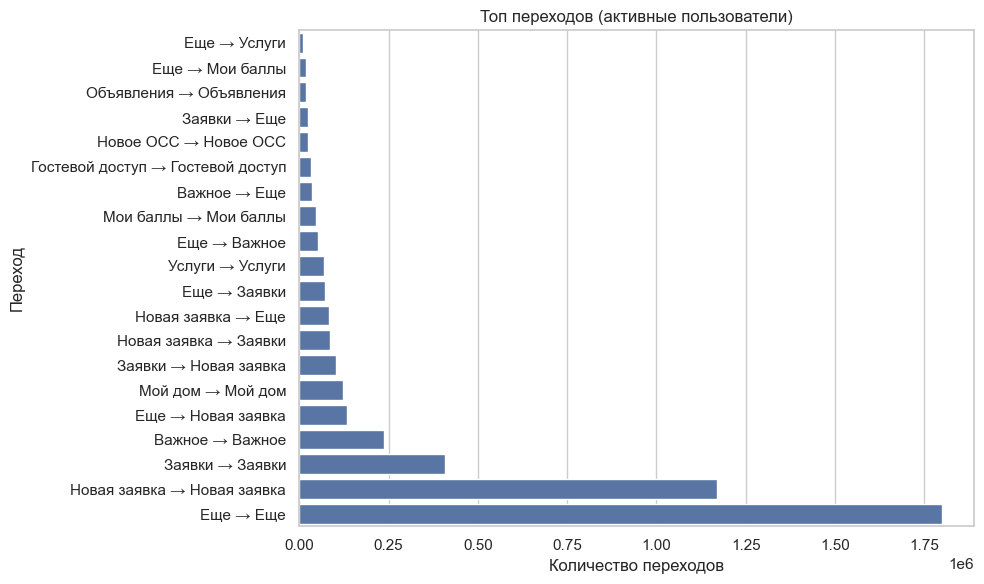

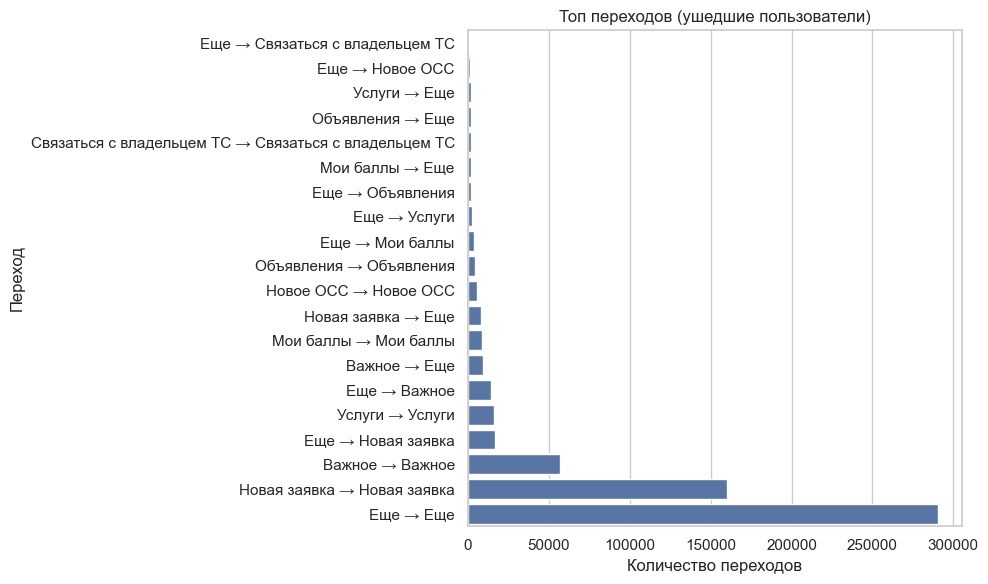

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 20

top_churn = (
    transitions_churn_count
    .query("churn_30d == 1")
    .sort_values('count', ascending=False)
    .head(top_n)
    .copy()
)

top_active = (
    transitions_churn_count
    .query("churn_30d == 0")
    .sort_values('count', ascending=False)
    .head(top_n)
    .copy()
)

def plot_top_transitions(df_top, title):
    df_plot = df_top.copy()
    
    # prev_screen и Экран у нас category → приводим к str
    df_plot['transition'] = (
        df_plot['prev_screen'].astype(str)
        + ' → '
        + df_plot['Экран'].astype(str)
    )
    
    # чтобы самые большие были сверху
    df_plot = df_plot.sort_values('count', ascending=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_plot,
        x='count',
        y='transition'
    )
    plt.title(title)
    plt.xlabel("Количество переходов")
    plt.ylabel("Переход")
    plt.tight_layout()
    plt.show()

plot_top_transitions(top_active, "Топ переходов (активные пользователи)")
plot_top_transitions(top_churn, "Топ переходов (ушедшие пользователи)")


### 3.3. “Блуждание”: доля возвратов/назад по churn

In [80]:
df_back = df.copy()

df_back['is_back'] = (
    (df_back['Функционал'] == 'Возврат на предыдущий этап') |
    (df_back['Действие'] == "Тап на стрелку назад")
)

df_back = df_back.merge(device_churn, on='Идентификатор устройства', how='left')

back_share = df_back.groupby('churn_30d')['is_back'].mean() * 100
print(back_share)


churn_30d
0    4.006587
1    4.934793
Name: is_back, dtype: float64


### 3.4. Journey с экрана «Ещё» для активных vs ушедших

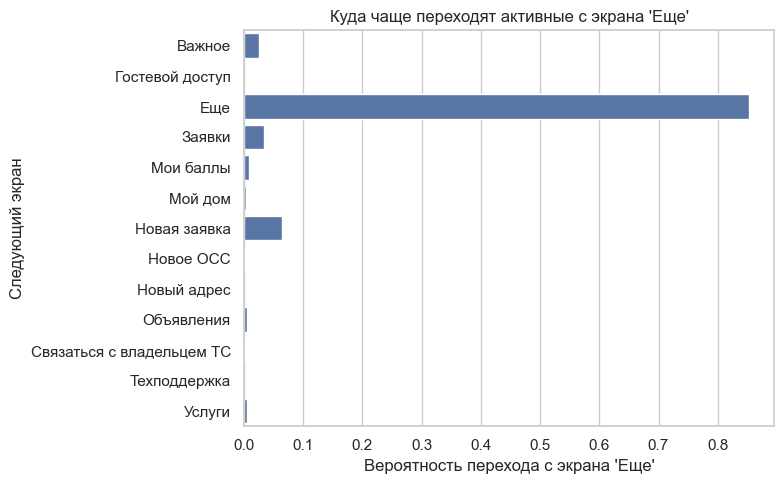

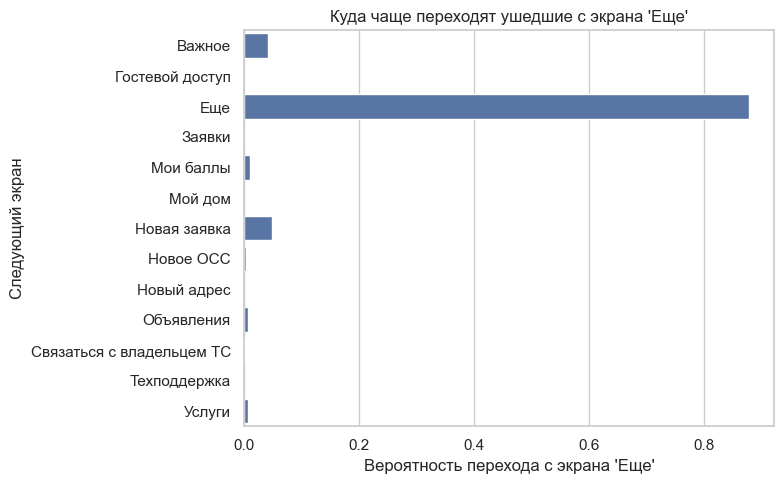

In [81]:
ej = transitions_churn_count[
    transitions_churn_count['prev_screen'] == 'Еще'
]

ej_active = (
    ej[ej['churn_30d'] == 0]
    .sort_values('prob', ascending=False)
    .head(10)
    .copy()
)

ej_churn = (
    ej[ej['churn_30d'] == 1]
    .sort_values('prob', ascending=False)
    .head(10)
    .copy()
)

def plot_from_main(df_top, title):
    plt.figure(figsize=(8, 5))
    # здесь y = 'Экран', category — seaborn с ним дружит
    sns.barplot(x='prob', y='Экран', data=df_top)
    plt.title(title)
    plt.xlabel("Вероятность перехода с экрана 'Еще'")
    plt.ylabel("Следующий экран")
    plt.tight_layout()
    plt.show()

plot_from_main(ej_active, "Куда чаще переходят активные с экрана 'Еще'")
plot_from_main(ej_churn,  "Куда чаще переходят ушедшие с экрана 'Еще'")


Пользовательский путь (customer journey) между ключевыми экранами приложения визуализирован с помощью диаграммы Санки. Эта диаграмма отображает основные переходы пользователей между экранами "Ещё", "Новая заявка", "Заявки", "Мой дом" и "Услуги".

Пользователи чаще всего переходят с экрана "Еще" на экран "Еще" (самый большой поток), что указывает на частое возвращение к главному меню. 

На диаграмме переходов ниже исключены самопереходы (например, “Ещё → Ещё”), чтобы лучше показать распределение переходов на другие экраны.

In [82]:
ej = transitions_churn_count[
    transitions_churn_count['prev_screen'] == 'Еще'
].copy()

# исключаем самопереходы "Еще → Еще"
ej = ej[ej['Экран'] != 'Еще'].copy()

# считаем нормализованную вероятность перехода
ej['prob_norm'] = ej.groupby('churn_30d')['count'].transform(lambda x: x / x.sum())

ej_active = (
    ej[ej['churn_30d'] == 0]
    .sort_values('prob_norm', ascending=False)
    .head(10)
)

ej_churn = (
    ej[ej['churn_30d'] == 1]
    .sort_values('prob_norm', ascending=False)
    .head(10)
)


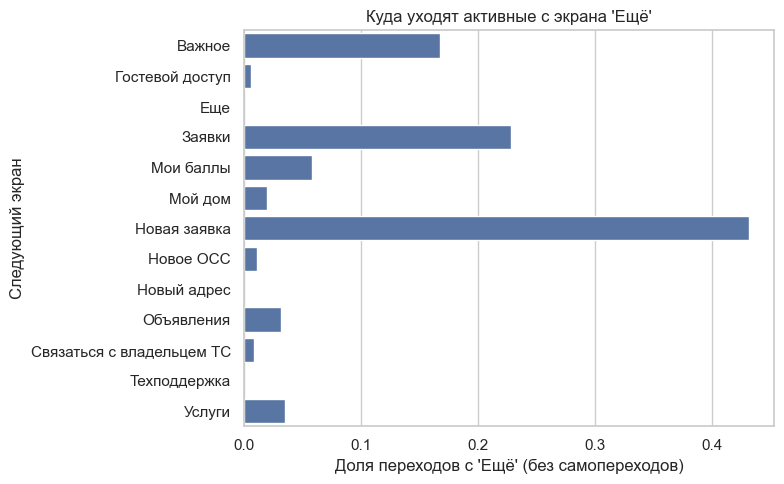

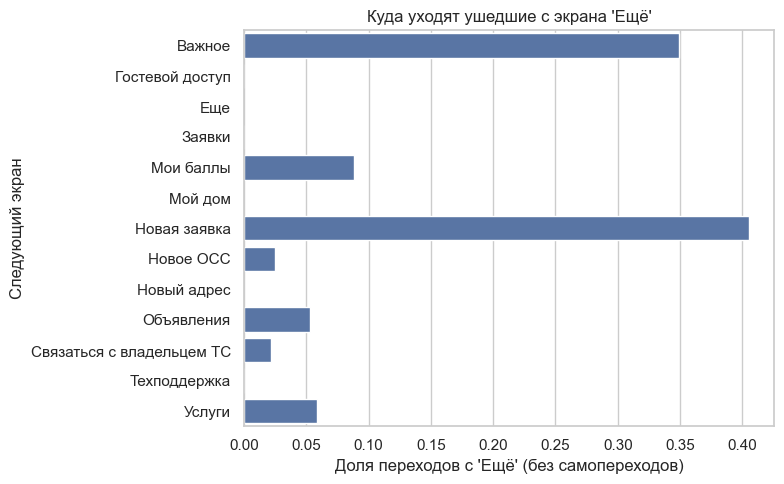

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_from_main(df_top, title):
    plt.figure(figsize=(8, 5))
    sns.barplot(x='prob_norm', y='Экран', data=df_top)
    plt.title(title)
    plt.xlabel("Доля переходов с 'Ещё' (без самопереходов)")
    plt.ylabel("Следующий экран")
    plt.tight_layout()
    plt.show()

plot_from_main(ej_active, "Куда уходят активные с экрана 'Ещё'")
plot_from_main(ej_churn,  "Куда уходят ушедшие с экрана 'Ещё'")


Гипотеза - ушедшие часто переходят на экран Важное и возможно ничего не находят там и уходят из приложения

У пользователей с оттоком доля действий “назад” чуть выше (4.9% против 4.0% у активных). Это может косвенно указывать на большее количество “блужданий” по экрану и сложности с навигацией, но разница невелика и требует дополнительной проверки.

In [85]:
import os

os.makedirs("data/processed", exist_ok=True)

processed_csv_path = "data/processed/events_clean.csv"
df.to_csv(processed_csv_path, index=False)
processed_csv_path


'data/processed/events_clean.csv'